In [1]:
import igraph
import networkx as nx
import netbone as nb
import numpy as np
import pandas as pd
import pickle

import os

In [2]:
from netbone.filters import threshold_filter
from netbone.measures import node_fraction, edge_fraction, average_degree, reachability, weight_fraction, density, weights, degrees
from netbone.visualize import plot_radar, plot_distribution

### Utils

In [3]:
# remove self-loops
def simplify_and_return(data: pd.DataFrame, directed=False, weighted=True, strategy="sum"):
    # Creating the corresponding igraph object
    print("Creating the igraph object from data...")
    g = igraph.Graph.TupleList(
                data[['source', 'target', 'weight']].itertuples(index=False),
                directed=False,
                weights=True)
    print("-"*50)

    # Some info on the graph
    print(f"g has {g.vcount()} nodes and {g.ecount()} edges")
    print(f"g is simple: {g.is_simple()}")
    print(f"g is weighted: {g.is_weighted()}")
    print("-"*50)

    # Simplifying the graph
    print("Simplifying g...")
    g = g.simplify(combine_edges=dict(weight=strategy))

    # Counting isolated
    degrees = g.degree()
    vertices_with_degree_zero = [v for v, d in enumerate(degrees) if d == 0]

    # Some info on the graph
    print(f"g has {g.vcount()} nodes and {g.ecount()} edges")
    print(f"g has {len(vertices_with_degree_zero)} isolated nodes")
    print(f"g is simple: {g.is_simple()}")
    print(f"g is weighted: {g.is_weighted()}")
    print("-"*50)

    # Returning to df
    print("Re-creating data (from simple graph)...")
    edgelist = [(g.vs[e.source]["name"], g.vs[e.target]["name"], g.es[idx]["weight"]) for idx, e in enumerate(g.es)]
    print(edgelist[:3])
    data_simple = pd.DataFrame(edgelist, columns=['source', 'target', 'weight'])
    data_simple['source'] = data_simple['source'].astype(str)
    data_simple['target'] = data_simple['target'].astype(str)
    data_simple['weight'] = data_simple['weight'].astype(int)
    print(data_simple.head())
    print("-"*50)
    
    return data_simple

### Loading the nets

In [4]:
# Reading data
basepath = '../../../data/02_network_data'
output_path = '../../../data/03_backbone_nets'

#### Original nets

In [5]:
before_data = pd.read_csv(os.path.join(basepath, 'before_campaign.graph'))
during_data = pd.read_csv(os.path.join(basepath, 'electoral_campaign.graph'))
after_data = pd.read_csv(os.path.join(basepath, 'after_elections.graph'))

# Forcing the conversion to string
before_data['source'] = before_data['source'].astype(str)
before_data['target'] = before_data['target'].astype(str)
during_data['source'] = during_data['source'].astype(str)
during_data['target'] = during_data['target'].astype(str)
after_data['source'] = after_data['source'].astype(str)
after_data['target'] = after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", before_data.shape)
print("During data has shape: ", during_data.shape)
print("After data has shape: ", after_data.shape)

Before data has shape:  (1013501, 3)
During data has shape:  (1373674, 3)
After data has shape:  (1330480, 3)


In [6]:
# Simplifying original nets
before_data = simplify_and_return(before_data)
during_data = simplify_and_return(during_data)
after_data = simplify_and_return(after_data)

Creating the igraph object from data...
--------------------------------------------------
g has 120644 nodes and 1013501 edges
g is simple: False
g is weighted: True
--------------------------------------------------
Simplifying g...
g has 120644 nodes and 1009968 edges
g has 30 isolated nodes
g is simple: True
g is weighted: True
--------------------------------------------------
Re-creating data (from simple graph)...
[('1111697667946659840', '52424550', 355.0), ('1111697667946659840', '289400495', 125.0), ('1111697667946659840', '2983707267', 114.0)]
                source              target  weight
0  1111697667946659840            52424550     355
1  1111697667946659840           289400495     125
2  1111697667946659840          2983707267     114
3  1111697667946659840           274093178      64
4  1111697667946659840  999578121123848192      35
--------------------------------------------------
Creating the igraph object from data...
------------------------------------------

In [13]:
# Creating graphs
# use nx.DIGraph() for directed graph
before_graph = nx.from_pandas_edgelist(before_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
during_graph = nx.from_pandas_edgelist(during_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
after_graph = nx.from_pandas_edgelist(after_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")

Before graph has:  120614  nodes and  1009968  edges
During graph has:  183688  nodes and  1366268  edges
After graph has:  253854  nodes and  1325370  edges


#### Representative nets

In [35]:
r_before_data = pd.read_csv(os.path.join(basepath, 'before_campaign_representative.graph'))
r_during_data = pd.read_csv(os.path.join(basepath, 'electoral_campaign_representative.graph'))
r_after_data = pd.read_csv(os.path.join(basepath, 'after_elections_representative.graph'))

# Forcing the conversion to string
r_before_data['source'] = r_before_data['source'].astype(str)
r_before_data['target'] = r_before_data['target'].astype(str)
r_during_data['source'] = r_during_data['source'].astype(str)
r_during_data['target'] = r_during_data['target'].astype(str)
r_after_data['source'] = r_after_data['source'].astype(str)
r_after_data['target'] = r_after_data['target'].astype(str)

# Shapes
print("Before data has shape: ", r_before_data.shape)
print("During data has shape: ", r_during_data.shape)
print("After data has shape: ", r_after_data.shape)

Before data has shape:  (72716, 3)
During data has shape:  (92920, 3)
After data has shape:  (91749, 3)


In [36]:
# Creating graphs
# use nx.DIGraph() for directed graph
r_before_graph = nx.from_pandas_edgelist(r_before_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
r_during_graph = nx.from_pandas_edgelist(r_during_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
r_after_graph = nx.from_pandas_edgelist(r_after_data, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())

# Some basic stats
print("Before graph has: ", r_before_graph.number_of_nodes(), " nodes and ", r_before_graph.number_of_edges(), " edges")
print("During graph has: ", r_during_graph.number_of_nodes(), " nodes and ", r_during_graph.number_of_edges(), " edges")
print("After graph has: ", r_after_graph.number_of_nodes(), " nodes and ", r_after_graph.number_of_edges(), " edges")

Before graph has:  34863  nodes and  72716  edges
During graph has:  46388  nodes and  92920  edges
After graph has:  66500  nodes and  91749  edges


### Network backboning

#### Before campaign

In [8]:
before_framework_path = os.path.join(output_path, 'netbone', 'before_framework.pkl')

if os.path.exists(before_framework_path):
    print("Loading data...")

    before_framework = pickle.load(open(os.path.join(output_path, 'netbone', 'before_framework.pkl'), 'rb'))

    backbone_data = pd.read_csv(os.path.join(output_path, 'before_campaign_backbone.csv'))
    backbone_data['source'] = backbone_data['source'].astype(str)
    backbone_data['target'] = backbone_data['target'].astype(str)
    backbone_data['weight'] = backbone_data['weight'].astype(int)

    b_consensual_backbone = nx.from_pandas_edgelist(backbone_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

In [14]:
before_framework = nb.compare.Compare()
before_framework.set_network(before_data)

#
# backbone methods
#
print("Disparity")
b_df = nb.disparity(before_data)

print("Marginal likelihood")
b_mlf = nb.marginal_likelihood(before_data) 

print("Noise corrected")
b_nc = nb.noise_corrected(before_data)

print("Local and non-local\n")
b_lans = nb.lans(before_data)

before_framework.add_backbone(b_df)
before_framework.add_backbone(b_mlf) 
before_framework.add_backbone(b_nc)
before_framework.add_backbone(b_lans)

#
# thrshold filters - which actually materialize the backbone
# - the filtering uses the significance value as a threshold
#
values = [0.05]*4 
before_framework.set_filter(threshold_filter, values)

b_df_backbone = threshold_filter(b_df, 0.05)
b_mlf_backbone = threshold_filter(b_mlf, 0.05)
b_nc_backbone = threshold_filter(b_nc, 0.05)
b_lans_backbone = threshold_filter(b_lans, 0.05)

#
# consensus backbone
#
b_consensual_backbone = before_framework.consent()

# print number of nodes and edges of before graph and consensual network
print()
print("Before graph has: ", before_graph.number_of_nodes(), " nodes and ", before_graph.number_of_edges(), " edges")
print("Consensual backbone has: ", b_consensual_backbone.number_of_nodes(), " nodes and ", b_consensual_backbone.number_of_edges(), " edges")

Disparity
Marginal likelihood
Noise corrected
Local and non-local

Disparity Filter
Marginal Likelihood Filter
Noise Corrected Filter
Locally Adaptive Network Sparsification Filter

Before graph has:  120614  nodes and  1009968  edges
Consensual backbone has:  12008  nodes and  38209  edges


In [10]:
# Saving data
pickle.dump(before_framework, open(os.path.join(output_path, 'netbone', 'before_framework.pkl'), 'wb'))

g_data = nx.to_pandas_edgelist(b_consensual_backbone)
g_data.to_csv(os.path.join(output_path, 'before_campaign_backbone.csv'), index=False)

In [11]:
#
# structural properties to analyze
#
before_framework.add_property('Node Fraction', node_fraction)
before_framework.add_property('Edge Fraction', edge_fraction)
before_framework.add_property('Weight Fraction', weight_fraction)
before_framework.add_property('Density', density)
before_framework.add_property('Average Degree', average_degree)
before_framework.add_property('Reachability', reachability)

# Now that everything is set up and added to the framework, we call the properties() function to
# compute the added properties. This function returns a pandas DataFrame that can be inspected to
# compare the computed properties of the backbones
b_results = before_framework.properties()

b_consensual_backbone_properties = [
    node_fraction(during_graph, b_consensual_backbone),
    edge_fraction(during_graph, b_consensual_backbone),
    weight_fraction(during_graph, b_consensual_backbone),
    density(during_graph, b_consensual_backbone),
    average_degree(during_graph, b_consensual_backbone),
    reachability(during_graph, b_consensual_backbone)
]

b_results.loc['consensual_backbone'] = b_consensual_backbone_properties

b_results

,Node Fraction,Edge Fraction,Weight Fraction,Density,Average Degree,Reachability
Original,1.000000,1.000000,1.000000,0.0001,16.747111,0.969874
Disparity Filter,0.099665,0.039349,0.251593,0.0006,6.611929,0.977838
Marginal Likelihood Filter,1.000000,0.801614,0.865854,0.0001,13.424710,0.969874
Noise Corrected Filter,1.000000,0.929080,0.939317,0.0001,15.559404,0.969874
Locally Adaptive Network Sparsification Filter,1.000000,0.450146,0.575815,0.0001,7.538644,0.968976
consensual_backbone,0.065372,0.027966,0.157900,0.0005,6.363924,0.977814


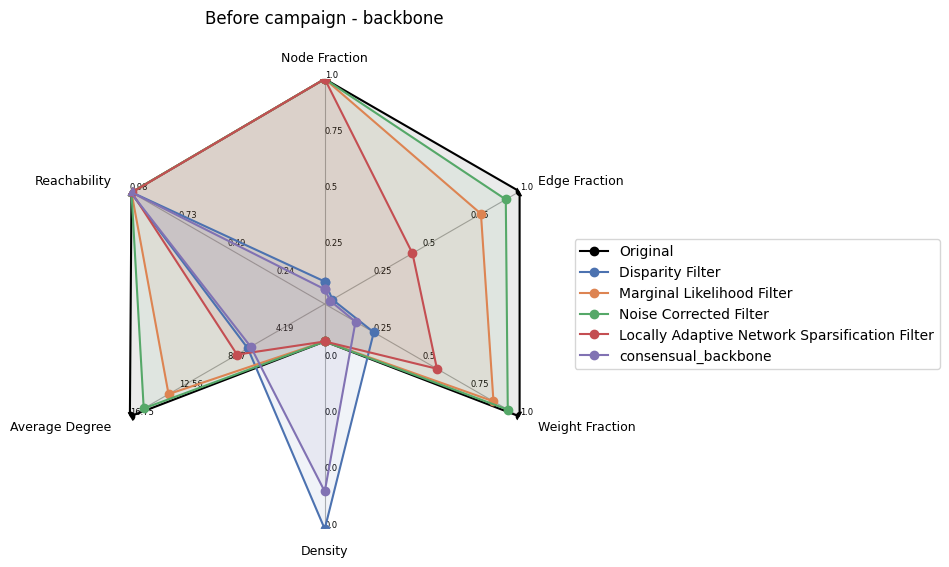

In [12]:
plot_radar(b_results, 'Before campaign - backbone')

In [15]:
#
# weight and degree distribution
#
b_framework1 = nb.compare.Compare()

b_framework1.set_network(before_data)

b_framework1.add_backbone(b_df)
b_framework1.add_backbone(b_mlf)
b_framework1.add_backbone(b_nc)
b_framework1.add_backbone(b_lans)

values = [0.05]*4 
b_framework1.set_filter(threshold_filter, values)

b_framework1.add_property('Weight', weights)
b_framework1.add_property('Degree', degrees)

b_results1, b_dist, b_consensual_back1 = b_framework1.distribution_ks_statistic(consent=[True, True, True, True])
b_results1

,Weight,Degree
Disparity Filter,0.937535,0.080480
Marginal Likelihood Filter,0.032595,0.009253
Noise Corrected Filter,0.001843,0.002446
Locally Adaptive Network Sparsification Filter,0.056510,0.092377
Consensual Backbone,0.937535,0.083610


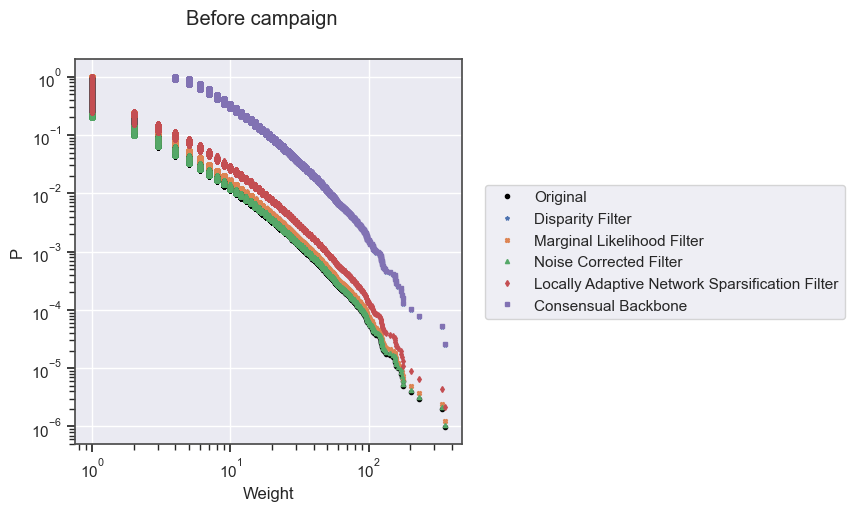

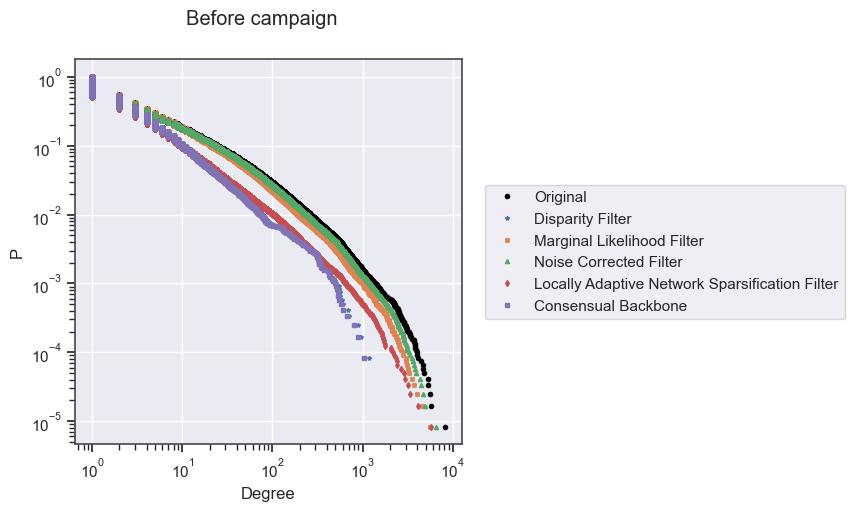

In [16]:
plot_distribution(b_dist, title='Before campaign')

#### During campaign

In [ ]:
during_framework = pickle.load(open(os.path.join(output_path, 'netbone', 'during_framework.pkl'), 'rb'))

if os.path.exists(during_framework):
    backbone_data = pd.read_csv(os.path.join(output_path, 'during_campaign_backbone.csv'))
    backbone_data['source'] = backbone_data['source'].astype(str)
    backbone_data['target'] = backbone_data['target'].astype(str)
    backbone_data['weight'] = backbone_data['weight'].astype(int)

    d_consensual_backbone = nx.from_pandas_edgelist(backbone_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

In [17]:
during_framework = nb.compare.Compare()
during_framework.set_network(during_data)

#
# backbone methods
#
print("Disparity")
d_df = nb.disparity(during_data)

print("Marginal likelihood")
d_mlf = nb.marginal_likelihood(during_data) 

print("Noise corrected")
d_nc = nb.noise_corrected(during_data)

print("Local and non-local\n")
d_lans = nb.lans(during_data)

during_framework.add_backbone(d_df)
during_framework.add_backbone(d_mlf) 
during_framework.add_backbone(d_nc)
during_framework.add_backbone(d_lans)

#
# filters - which actually materialize the backbone
#
values = [0.05]*4 
during_framework.set_filter(threshold_filter, values)

d_df_backbone = threshold_filter(d_df, 0.05)
d_mlf_backbone = threshold_filter(d_mlf, 0.05)
d_nc_backbone = threshold_filter(d_nc, 0.05)
d_lans_backbone = threshold_filter(d_lans, 0.05)

#
# consensus backbone
#
d_consensual_backbone = during_framework.consent()

# print number of nodes and edges of before graph and consensual network
print()
print("During graph has: ", during_graph.number_of_nodes(), " nodes and ", during_graph.number_of_edges(), " edges")
print("Consensual backbone has: ", d_consensual_backbone.number_of_nodes(), " nodes and ", d_consensual_backbone.number_of_edges(), " edges")

Disparity
Marginal likelihood
Noise corrected
Local and non-local

Disparity Filter
Marginal Likelihood Filter
Noise Corrected Filter
Locally Adaptive Network Sparsification Filter

During graph has:  183688  nodes and  1366268  edges
Consensual backbone has:  18150  nodes and  56953  edges


In [18]:
pickle.dump(during_framework, open(os.path.join(output_path, 'netbone', 'during_framework.pkl'), 'wb'))

g_data = nx.to_pandas_edgelist(d_consensual_backbone)
g_data.to_csv(os.path.join(output_path, 'during_campaign_backbone.csv'), index=False)

In [19]:
#
# structural properties to analyze
#
during_framework.add_property('Node Fraction', node_fraction)
during_framework.add_property('Edge Fraction', edge_fraction)
during_framework.add_property('Weight Fraction', weight_fraction)
during_framework.add_property('Density', density)
during_framework.add_property('Average Degree', average_degree)
during_framework.add_property('Reachability', reachability)

d_results = during_framework.properties()

d_consensual_backbone_properties = [
    node_fraction(during_graph, d_consensual_backbone),
    edge_fraction(during_graph, d_consensual_backbone),
    weight_fraction(during_graph, d_consensual_backbone),
    density(during_graph, d_consensual_backbone),
    average_degree(during_graph, d_consensual_backbone),
    reachability(during_graph, d_consensual_backbone)
]

d_results.loc['consensual_backbone'] = d_consensual_backbone_properties

d_results

,Node Fraction,Edge Fraction,Weight Fraction,Density,Average Degree,Reachability
Original,1.000000,1.000000,1.000000,0.0001,14.875964,0.946061
Disparity Filter,0.098885,0.043853,0.326041,0.0004,6.597115,0.894290
Marginal Likelihood Filter,1.000000,0.824523,0.893100,0.0001,12.265570,0.946061
Noise Corrected Filter,1.000000,0.931784,0.943894,0.0001,13.861189,0.946061
Locally Adaptive Network Sparsification Filter,1.000000,0.413240,0.584965,0.0000,6.147348,0.938842
consensual_backbone,0.098809,0.041685,0.313754,0.0003,6.275813,0.893377


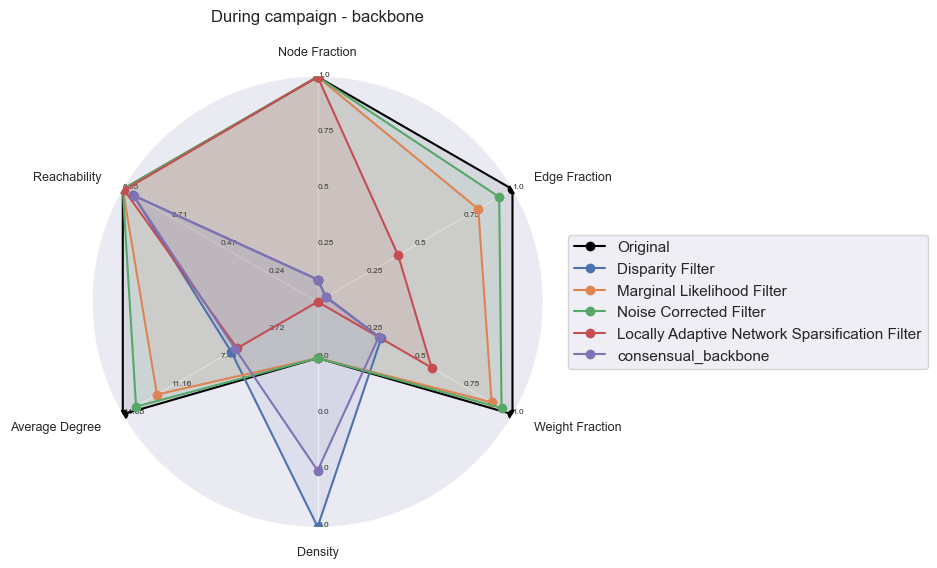

In [20]:
plot_radar(d_results, 'During campaign - backbone')

In [21]:
#
# weight and degree distribution
#
d_framework1 = nb.compare.Compare()

d_framework1.set_network(during_data)

d_framework1.add_backbone(d_df)
d_framework1.add_backbone(d_mlf)
d_framework1.add_backbone(d_nc)
d_framework1.add_backbone(d_lans)

values = [0.05]*4 
d_framework1.set_filter(threshold_filter, values)

d_framework1.add_property('Weight', weights)
d_framework1.add_property('Degree', degrees)

d_results1, d_dist, d_consensual_back1 = d_framework1.distribution_ks_statistic(consent=[True, True, True, True])
d_results1

,Weight,Degree
Disparity Filter,0.926539,0.054287
Marginal Likelihood Filter,0.028461,0.005008
Noise Corrected Filter,0.001697,0.001334
Locally Adaptive Network Sparsification Filter,0.065591,0.088171
Consensual Backbone,0.926539,0.058491


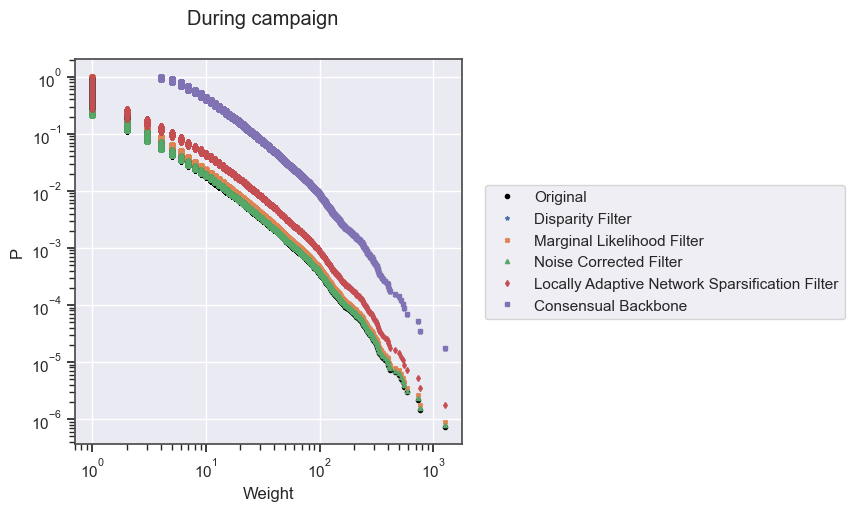

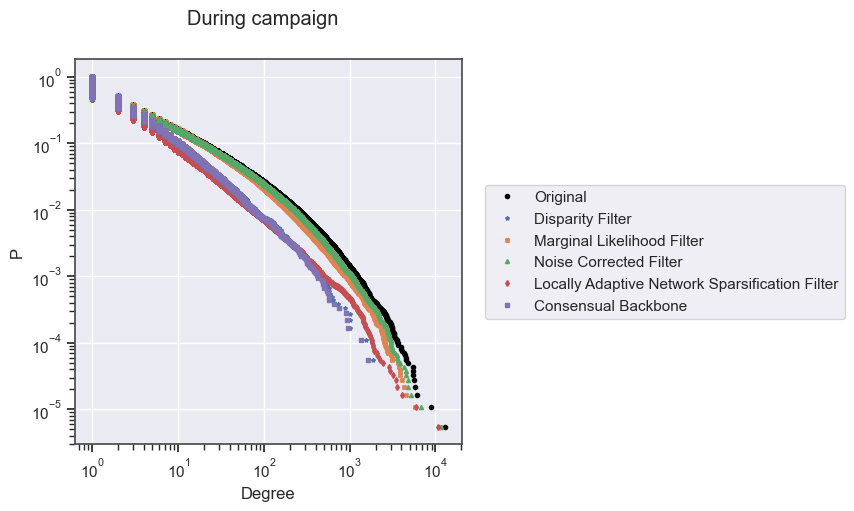

In [22]:
plot_distribution(d_dist, title='During campaign')

#### After elections

In [ ]:
after_framework = pickle.load(open(os.path.join(output_path, 'netbone', 'after_framework.pkl'), 'rb'))

if os.path.exists(after_framework):
    backbone_data = pd.read_csv(os.path.join(output_path, 'after_elections_backbone.csv'))
    backbone_data['source'] = backbone_data['source'].astype(str)
    backbone_data['target'] = backbone_data['target'].astype(str)
    backbone_data['weight'] = backbone_data['weight'].astype(int)

    a_consensual_backbone = nx.from_pandas_edgelist(backbone_data, source='source', target='target', edge_attr='weight', create_using=nx.Graph())

In [23]:
after_framework = nb.compare.Compare()
after_framework.set_network(after_data)

#
# backbone methods
#
print("Disparity")
a_df = nb.disparity(after_data)

print("Marginal likelihood")
a_mlf = nb.marginal_likelihood(after_data) 

print("Noise corrected")
a_nc = nb.noise_corrected(after_data)

print("Local and non-local\n")
a_lans = nb.lans(after_data)

after_framework.add_backbone(a_df)
after_framework.add_backbone(a_mlf) 
after_framework.add_backbone(a_nc)
after_framework.add_backbone(a_lans)

#
# filters - which actually materialize the backbone
#
values = [0.05]*4 
after_framework.set_filter(threshold_filter, values)

a_df_backbone = threshold_filter(a_df, 0.05)
a_mlf_backbone = threshold_filter(a_mlf, 0.05)
a_nc_backbone = threshold_filter(a_nc, 0.05)
a_lans_backbone = threshold_filter(a_lans, 0.05)

#
# consensus backbone
#
a_consensual_backbone = after_framework.consent()

# print number of nodes and edges of before graph and consensual network
print()
print("After graph has: ", after_graph.number_of_nodes(), " nodes and ", after_graph.number_of_edges(), " edges")
print("Consensual backbone has: ", a_consensual_backbone.number_of_nodes(), " nodes and ", a_consensual_backbone.number_of_edges(), " edges")

Disparity
Marginal likelihood
Noise corrected
Local and non-local

Disparity Filter
Marginal Likelihood Filter
Noise Corrected Filter
Locally Adaptive Network Sparsification Filter

After graph has:  253854  nodes and  1325370  edges
Consensual backbone has:  15943  nodes and  42864  edges


In [24]:
pickle.dump(after_framework, open(os.path.join(output_path, 'netbone', 'after_framework.pkl'), 'wb'))

g_data = nx.to_pandas_edgelist(a_consensual_backbone)
g_data.to_csv(os.path.join(output_path, 'after_elections_backbone.csv'), index=False)

In [25]:
#
# structural properties to analyze
#
after_framework.add_property('Node Fraction', node_fraction)
after_framework.add_property('Edge Fraction', edge_fraction)
after_framework.add_property('Weight Fraction', weight_fraction)
after_framework.add_property('Density', density)
after_framework.add_property('Average Degree', average_degree)
after_framework.add_property('Reachability', reachability)

a_results = after_framework.properties()

a_consensual_backbone_properties = [
    node_fraction(after_graph, a_consensual_backbone),
    edge_fraction(after_graph, a_consensual_backbone),
    weight_fraction(after_graph, a_consensual_backbone),
    density(after_graph, a_consensual_backbone),
    average_degree(after_graph, a_consensual_backbone),
    reachability(after_graph, a_consensual_backbone)
]

a_results.loc['consensual_backbone'] = a_consensual_backbone_properties

a_results

,Node Fraction,Edge Fraction,Weight Fraction,Density,Average Degree,Reachability
Original,1.000000,1.000000,1.000000,0.0000,10.441986,0.947482
Disparity Filter,0.062879,0.033536,0.233432,0.0003,5.569227,0.881462
Marginal Likelihood Filter,1.000000,0.873380,0.909790,0.0000,9.119817,0.947106
Noise Corrected Filter,1.000000,0.956796,0.960180,0.0000,9.990853,0.947482
Locally Adaptive Network Sparsification Filter,1.000000,0.532163,0.627424,0.0000,5.556840,0.943161
consensual_backbone,0.062804,0.032341,0.226516,0.0003,5.377156,0.880619


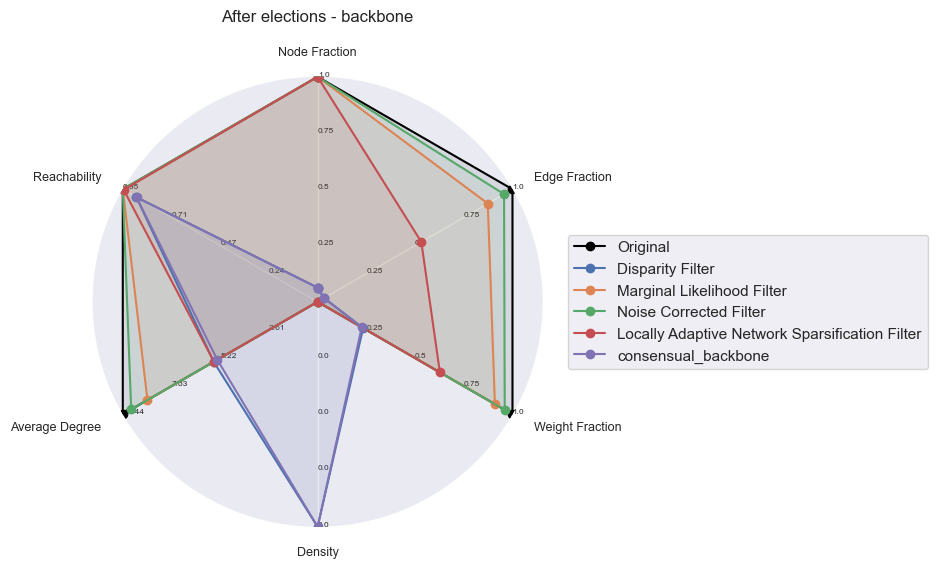

In [26]:
plot_radar(a_results, 'After elections - backbone')

In [27]:
#
# weight and degree distribution
#
a_framework1 = nb.compare.Compare()

a_framework1.set_network(after_data)

a_framework1.add_backbone(a_df)
a_framework1.add_backbone(a_mlf)
a_framework1.add_backbone(a_nc)
a_framework1.add_backbone(a_lans)

values = [0.05]*4 
a_framework1.set_filter(threshold_filter, values)

a_framework1.add_property('Weight', weights)
a_framework1.add_property('Degree', degrees)

a_results1, a_dist, a_consensual_back1 = a_framework1.distribution_ks_statistic(consent=[True, True, True, True])
a_results1

,Weight,Degree
Disparity Filter,0.947473,0.030331
Marginal Likelihood Filter,0.015726,0.003329
Noise Corrected Filter,0.001166,0.000784
Locally Adaptive Network Sparsification Filter,0.031908,0.053984
Consensual Backbone,0.947472,0.032974


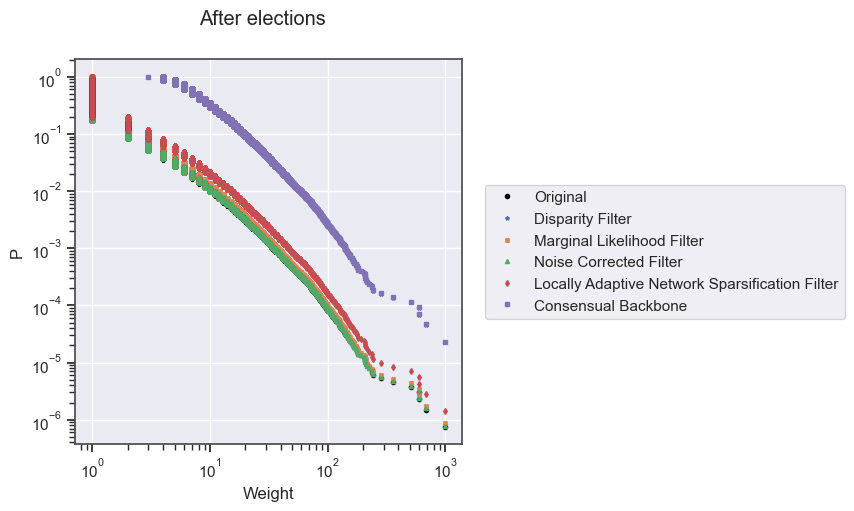

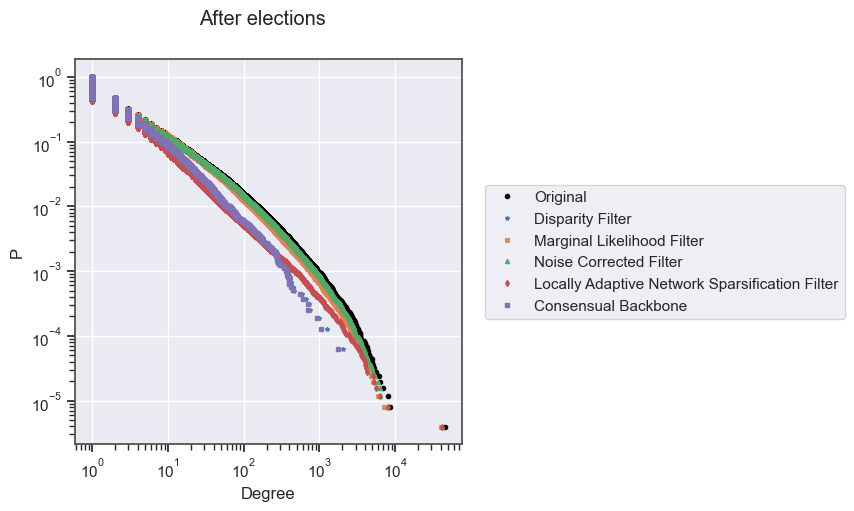

In [28]:
plot_distribution(a_dist, title='After elections')